# **Identifying Nutrient Deficiencies in Satellite Farmland Imagery**
## 00: Data Retrieval

**IMPORTANT NOTE**: The prerequisite for this notebook is that the steps in [Data Retrieval and Model Training Setup](../Data_Retrieval_and_Model_Training_Setup.md) have been completed.

This notebook must be in the `code/` folder, and the parent folder to this folder must include the `data2018_miniscale` folder of image data before code cells in this note book can be run.

---

This notebook accomplishes the following:
* Parses the `field_stats.json` file in `../data2018_miniscale/` to determine which images in the dataset have **nutrient deficiency** annotations.
* Once the image names are collected, they are moved into the `../data/` directory and organized into subfolders for `features` (the RGB images), `nir_features` (the near-infrared image channel), and `labels` (the ground truth nutrient deficiency segmentation annotations).
* Saves the metadata from `field_stats.json` above into a dataframe along with the image names for later use.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
np.random.seed(42)

In [2]:
#image reviewing method inspired by Renu Khandelwhal: 
#https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6

import os
import matplotlib.image as mpimg
%matplotlib inline

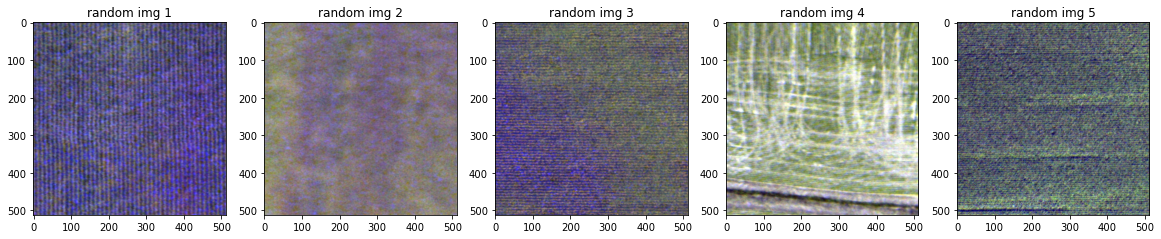

In [3]:
plt.figure(figsize=(20,20))

folder=r'..\data2018_miniscale\field_images\rgb'
for i in range(5):
    file = np.random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text(f'random img {i+1}')
    plt.imshow(img)

---

### Determine which of our files have nutrient deficiency by parsing the `field_stats.json` file:

In [4]:
#retrieve a list of photos which are in our dataset:

def get_dataset(split, label='nutrient_deficiency'):
    data = pd.DataFrame(pd.read_json('../data2018_miniscale/field_stats.json')[split].dropna())
    prefix = '../datasets/data2018_miniscale/field_bounds/'
    #should return a list of image names with no filetype:
    return [x[1].replace(prefix, '').replace('.png','') for x in zip([x['label_counts'][label] for x in data[split]],data.index) if x[0]]

In [5]:
splits = ['train','test','val']
dataset_photos = []

for split in splits:
    dataset_photos += get_dataset(split)

In [6]:
#each of the photos in this list has at least one area labelled with nutrient deficiency.
dataset_photos[:5]

['PGG8PQWFU_1111-9821-1623-10333',
 '6BHUDYJCH_8734-779-9246-1291',
 'CNGC37HJN_2837-7381-3349-7893',
 '28N9MQYAR_5265-1367-5777-1879',
 'KJQB97LNW_5964-3774-6476-4286']

In [7]:
#move the photos:
for photo in dataset_photos:
    os.replace(f'../data2018_miniscale/field_images/rgb/{photo}.jpg',f'../data/features/{photo}.jpg')    

In [8]:
#move the near-infrared images:
for photo in dataset_photos:
    os.replace(f'../data2018_miniscale/field_images/nir/{photo}.jpg',f'../data/nir_features/{photo}.jpg')

In [9]:
#move the labels (farmer-annotated overlays):
for photo in dataset_photos:
    os.replace(f'../data2018_miniscale/field_labels/nutrient_deficiency/{photo}.png',f'../data/labels/{photo}.png')

In [10]:
pd.DataFrame(dataset_photos,columns=['image_name']).to_csv('../data/image_names.csv',index=False)

---

In [11]:
metadata = pd.DataFrame(columns=['nutrient_deficiency','image_area','nutrient_deficiency_area','size1','size2','image_name'])

In [12]:
for split in splits:
    data = pd.DataFrame(pd.read_json('../data2018_miniscale/field_stats.json')[split].dropna())
    data = pd.DataFrame(zip([int(x['label_counts']['nutrient_deficiency']) for x in data[split]]
                            ,[x['image_area'] for x in data[split]]
                            ,[float(x['label_areas']['nutrient_deficiency'][0] if x['label_areas']['nutrient_deficiency'] else 0) for x in data[split]]
                            ,[x['image_size'][0] for x in data[split]]
                            ,[x['image_size'][1] for x in data[split]]
                            ,data.index)
                        ,columns=['nutrient_deficiency','image_area','nutrient_deficiency_area','size1','size2','image_name'])
    metadata = metadata.append(data)

In [13]:
metadata.shape

(64014, 6)

In [14]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64014 entries, 0 to 12506
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   nutrient_deficiency       64014 non-null  object 
 1   image_area                64014 non-null  float64
 2   nutrient_deficiency_area  64014 non-null  float64
 3   size1                     64014 non-null  object 
 4   size2                     64014 non-null  object 
 5   image_name                64014 non-null  object 
dtypes: float64(2), object(4)
memory usage: 3.4+ MB


In [15]:
metadata = metadata[metadata['nutrient_deficiency']!=0]

In [16]:
#cast the int fields as ints:
int_fields = ['nutrient_deficiency','size1','size2']
for field in int_fields:
    metadata[field] = metadata[field].astype(int)

In [17]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14712 entries, 0 to 12505
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   nutrient_deficiency       14712 non-null  int32  
 1   image_area                14712 non-null  float64
 2   nutrient_deficiency_area  14712 non-null  float64
 3   size1                     14712 non-null  int32  
 4   size2                     14712 non-null  int32  
 5   image_name                14712 non-null  object 
dtypes: float64(2), int32(3), object(1)
memory usage: 632.2+ KB


In [18]:
metadata['image_name'] = [x.replace('../datasets/data2018_miniscale/field_bounds/','').replace('.png','') for x in metadata['image_name']]

In [19]:
metadata.reset_index(inplace=True)

In [20]:
metadata.drop(columns=['index'],inplace=True)

In [21]:
metadata

,nutrient_deficiency,image_area,nutrient_deficiency_area,size1,size2,image_name
0,1,233079.0,112243.0,512,512,PGG8PQWFU_1111-9821-1623-10333
1,1,262144.0,9073.0,512,512,6BHUDYJCH_8734-779-9246-1291
2,1,195791.0,134446.0,512,512,CNGC37HJN_2837-7381-3349-7893
3,1,262144.0,59919.0,512,512,28N9MQYAR_5265-1367-5777-1879
4,1,258038.0,82802.0,512,512,KJQB97LNW_5964-3774-6476-4286
...,...,...,...,...,...,...
14707,1,188450.0,115003.0,512,512,UI61WZB8F_5386-2703-5898-3215
14708,1,212480.0,31386.0,512,512,ACD6XFXY2_753-7244-1265-7756
14709,1,248841.0,66258.0,512,512,WEWNX366J_9909-6971-10421-7483
14710,1,262144.0,78130.0,512,512,UTV6183B6_7741-3779-8253-4291


In [22]:
metadata.describe().T[['mean','std','min','max']]

,mean,std,min,max
nutrient_deficiency,1.175979,0.453642,1.0,10.0
image_area,248299.332993,33626.842322,3936.0,262144.0
nutrient_deficiency_area,86597.671153,65185.881472,1.0,249003.0
size1,512.000000,0.000000,512.0,512.0
size2,512.000000,0.000000,512.0,512.0


---

Write the metadata to a .csv file.

In [23]:
metadata.to_csv('../data/image_metadata.csv',index=False)